In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os
from pathlib import Path

In [2]:
cur_file_path = Path().resolve()
par_file_path = cur_file_path.parent
#print(str(cur_file_path)+"/h-and-m-personalized-fashion-recommendations")
articles = pd.read_csv(str(par_file_path)+"/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv(str(par_file_path)+"/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv(str(par_file_path)+"/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

In [3]:
for col in articles.columns:
    if not 'no' in col and not 'code' in col and not 'id' in col:
        un_n = articles[col].nunique()
        print(f'n of unique {col}: {un_n}')

n of unique prod_name: 45875
n of unique product_type_name: 131
n of unique product_group_name: 19
n of unique graphical_appearance_name: 30
n of unique colour_group_name: 50
n of unique perceived_colour_value_name: 8
n of unique perceived_colour_master_name: 20
n of unique department_name: 250
n of unique index_name: 10
n of unique index_group_name: 5
n of unique section_name: 56
n of unique garment_group_name: 21
n of unique detail_desc: 43404


In [4]:
import os

# Clone the repository if it doesn't exist
if not os.path.exists('./Transformer-MM-Explainability'):
    !git clone https://github.com/hila-chefer/Transformer-MM-Explainability

os.chdir(f'./Transformer-MM-Explainability')

import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

Cloning into 'Transformer-MM-Explainability'...
remote: Enumerating objects: 1477, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 1477 (delta 90), reused 85 (delta 85), pack-reused 1324 (from 1)
Receiving objects: 100% (1477/1477), 25.57 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (578/578), done.


In [5]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [6]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    # one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    one_hot = torch.sum(one_hot * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last layer 
      start_layer = len(image_attn_blocks) - 1
    
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1: 
      # calculate index of last layer 
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text
   
    return text_relevance, image_relevance

In [7]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    # image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = image_relevance.reshape(224, 224).data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [8]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [9]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [11]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

tensor([0.0534, 0.0855, 0.2600, 0.0428, 0.5583])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of ladies wear


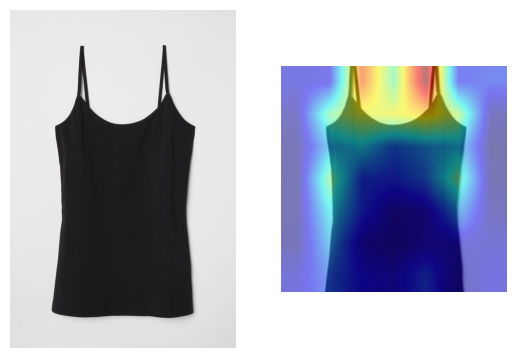

tensor([0.0716, 0.1823, 0.4805, 0.0772, 0.0388, 0.1496])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of baby / children


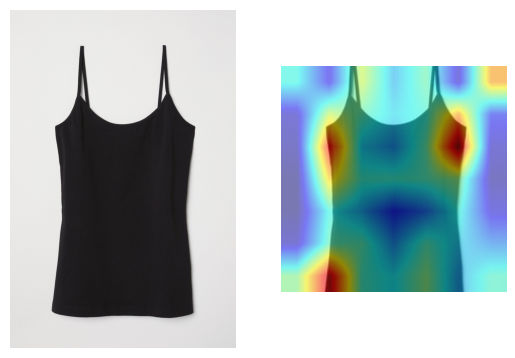

tensor([0.0322, 0.0737, 0.1894, 0.7047])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of menswear


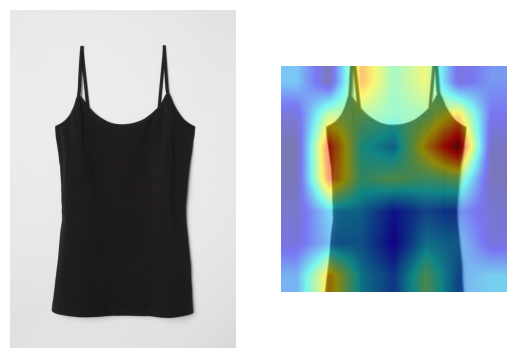

tensor([0.0767, 0.1917, 0.4071, 0.3245])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of sport


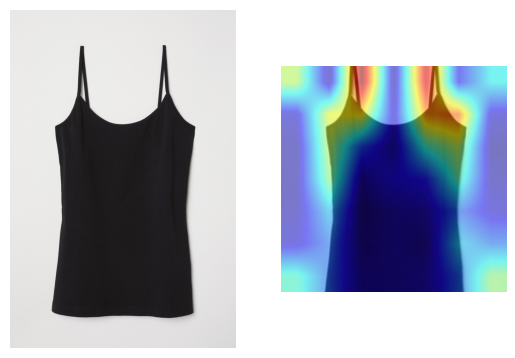

tensor([0.0798, 0.1558, 0.2401, 0.5244])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of divided


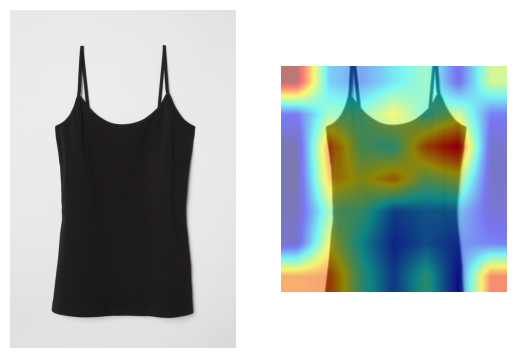

In [25]:
index_group_name = articles['index_group_name'].unique()

img_path = "/Users/tobiaspeihengli/Downloads/DD2430/h-and-m-personalized-fashion-recommendations/images/010/0108775015.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = [f"a photo of {index}" for index in index_group_name]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0167, 0.0168, 0.0483, 0.9181, 0.0000])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,it is a dark cloth


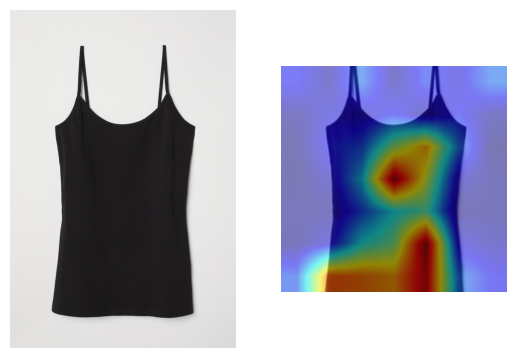

tensor([6.1317e-05, 1.7977e-02, 4.7833e-02, 1.0866e-01, 8.2547e-01])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,it is a light cloth


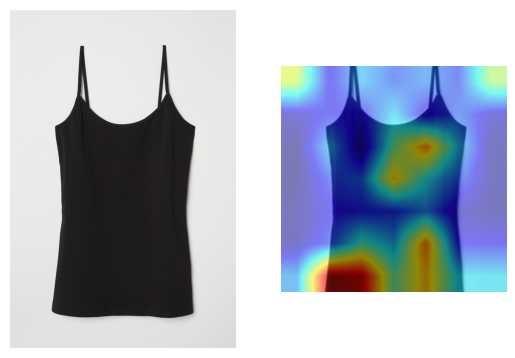

tensor([0.0031, 0.0112, 0.0302, 0.2566, 0.1099, 0.5890])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,it is a dusty light cloth


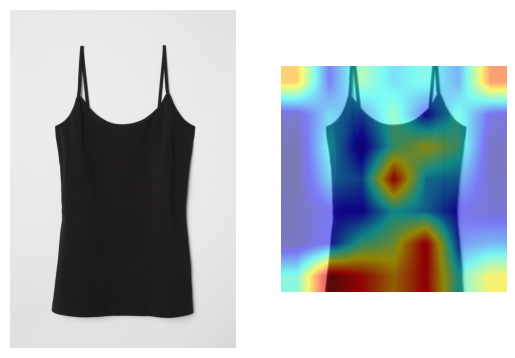

tensor([0.0023, 0.0165, 0.0497, 0.3054, 0.1890, 0.4371])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,it is a medium dusty cloth


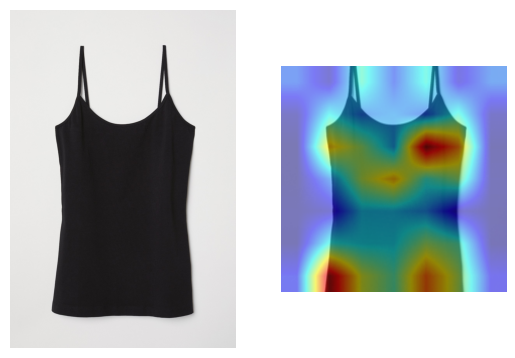

tensor([0.0183, 0.0218, 0.0819, 0.6855, 0.1925])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,it is a bright cloth


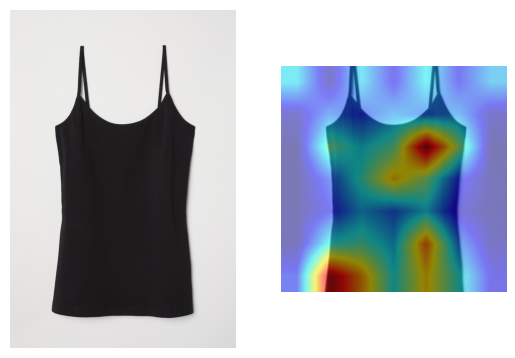

tensor([0.0000, 0.0205, 0.0726, 0.5024, 0.4045])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,it is a medium cloth


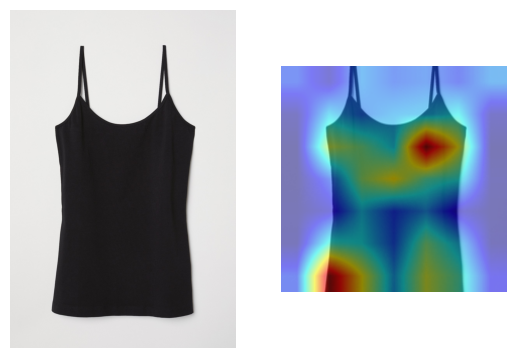

tensor([0.0263, 0.0221, 0.1031, 0.2996, 0.2459, 0.3030])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,it is a un defined cloth


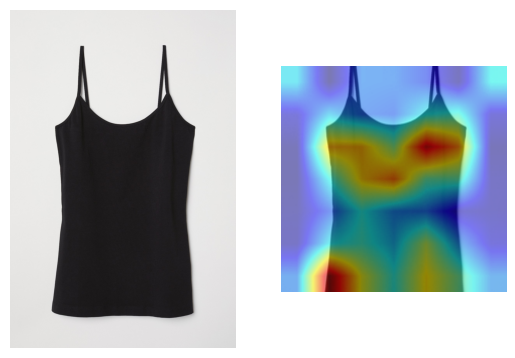

tensor([0.0022, 0.0131, 0.0568, 0.0889, 0.8389])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,it is a unknown cloth


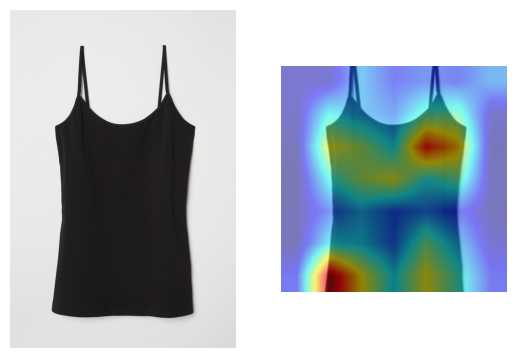

In [19]:
perceived_colour_value_name = articles['perceived_colour_value_name'].unique()

img_path = "/Users/tobiaspeihengli/Downloads/DD2430/h-and-m-personalized-fashion-recommendations/images/010/0108775015.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = [f"It is a {index} cloth" for index in perceived_colour_value_name]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()

tensor([0.0879, 0.1656, 0.2137, 0.5328])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of dark


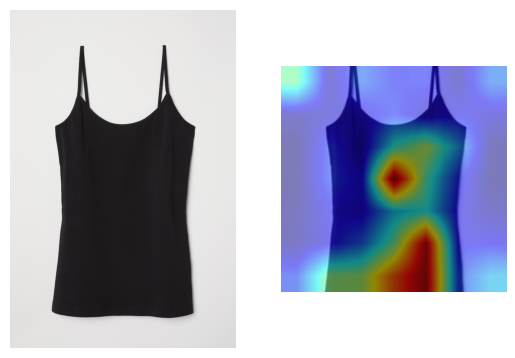

tensor([0.1705, 0.3101, 0.3051, 0.2142])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of light


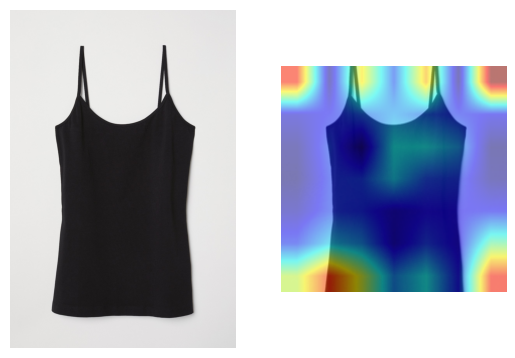

tensor([0.0614, 0.1076, 0.1621, 0.4716, 0.1973])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of dusty light


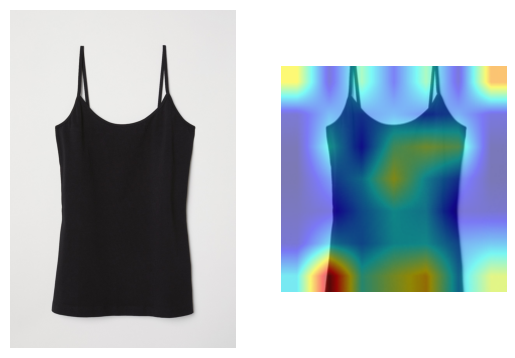

tensor([0.0331, 0.0497, 0.1501, 0.2894, 0.4776])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of medium dusty


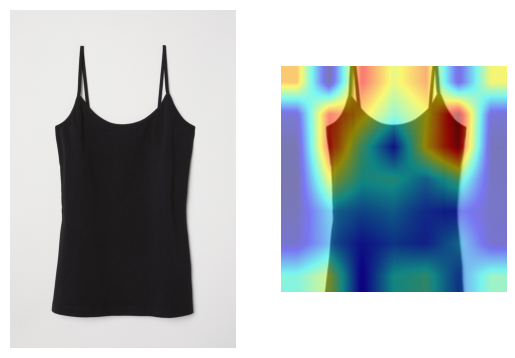

tensor([0.0829, 0.1270, 0.2837, 0.5064])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of bright


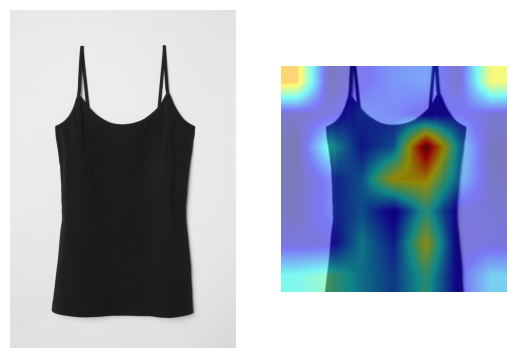

tensor([0.0491, 0.1071, 0.1303, 0.7135])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of medium


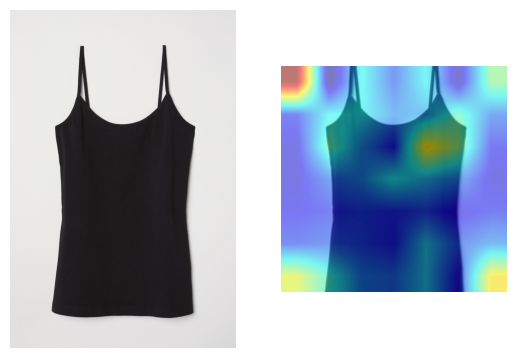

tensor([0.2088, 0.1774, 0.3028, 0.2555, 0.0553])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of un defined


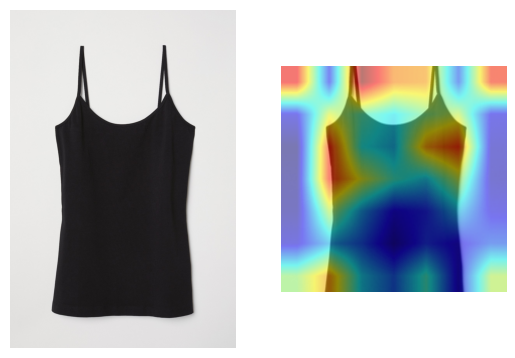

tensor([0.0694, 0.2037, 0.2623, 0.4647])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a photo of unknown


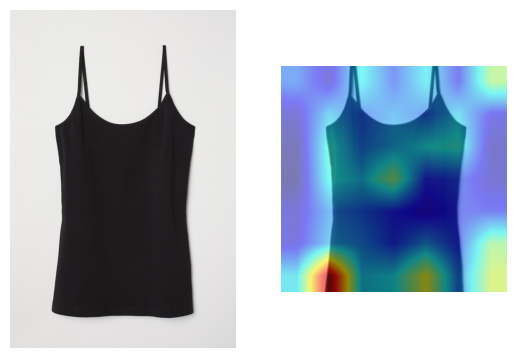

In [26]:
perceived_colour_value_name = articles['perceived_colour_value_name'].unique()

img_path = "/Users/tobiaspeihengli/Downloads/DD2430/h-and-m-personalized-fashion-recommendations/images/010/0108775015.jpg"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = [f"a photo of {index}" for index in perceived_colour_value_name]
text = clip.tokenize(texts).to(device)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
  show_heatmap_on_text(texts[i], text[i], R_text[i])
  show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
  plt.show()